#setup:
- connect to google drive in this step

In [ ]:
import pandas as pd
import math
import numpy as np
import os
import glob
import sklearn
import pickle
import glob
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = '/content/drive/MyDrive/demo-me-2021-07-14'
output_dir = os.path.join(project_path, "behaviors/")
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

In [ ]:
def get_data(individual, bodypart, h5_file):
  mouse_data = h5_file.xs(individual,level='individuals',axis=1)
  out_data = mouse_data.xs(bodypart,level='bodyparts',axis=1)
  out_data.columns = out_data.columns.droplevel("scorer")
  output = out_data.copy()
  return output

In [ ]:
def within_area(area_vector, input_coor):
  area_startx = area_vector[0]
  area_starty = area_vector[1]
  area_distx = area_vector[2]
  area_disty = area_vector[3]
  x = input_coor["x"].iloc[0]
  y = input_coor["y"].iloc[0]
  if (area_startx <= x <= (area_startx+area_distx)) and (area_starty <= y <= (area_starty+area_disty)):
    result = 1
  else:
    result = 0
  return result

In [ ]:
def euclid_dist(point1_coor, point2_coor):
  point1 = np.array((point1_coor["x"].iloc[0], point1_coor["y"].iloc[0]))
  point2 = np.array((point2_coor["x"].iloc[0], point2_coor["y"].iloc[0]))
  output_dist = np.linalg.norm(point1 - point2)
  return output_dist

In [ ]:
def euclid_angle(pointa_coor, pointb_coor, pointc_coor):
  #angle_{pointa, pointb, pointc}
  a = np.array((pointa_coor["x"].iloc[0], pointa_coor["y"].iloc[0]))
  b = np.array((pointb_coor["x"].iloc[0], pointb_coor["y"].iloc[0]))
  c = np.array((pointc_coor["x"].iloc[0], pointc_coor["y"].iloc[0]))

  ba = a - b
  bc = c - b

  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
  angle = np.arccos(cosine_angle)

  result = np.degrees(angle)
  return result

#Open some corrected_behavior data and mount_events data:

In [ ]:
video_name = 'PZ71_1'

corrected_behavior_file = open(output_dir + video_name + '_corrected_behavior.pickle', 'rb')
corrected_behavior = pickle.load(corrected_behavior_file)
corrected_behavior_file.close()

# area_vec = [area_startx, area_starty, area_distx, area_disty]
female_side_mat = scipy.io.loadmat(project_path + "/videos/" + video_name + "_female_side.mat")
female_side_vec = female_side_mat['croprect'][0]
male_side_mat = scipy.io.loadmat(project_path + "/videos/" + video_name + "_male_side.mat")
male_side_vec = male_side_mat['croprect'][0]

h5_file = pd.read_hdf(project_path +'/videos/'+ video_name + 'DLC_dlcrnetms5_demoJul14shuffle0_20000_el_filtered.h5')
[nframes, ncols] = h5_file.shape

#Open previously calculated training_mount_examples or training_nonmount_examples

In [ ]:
training_mount_examples_file = open(output_dir + video_name + '_training_mount_examples.pickle', 'rb')
training_mount_examples = pickle.load(training_mount_examples_file)
training_mount_examples_file.close()

FileNotFoundError: ignored

In [ ]:
training_nonmount_examples_file = open(output_dir + video_name + '_training_nonmount_examples.pickle', 'rb')
training_nonmount_examples = pickle.load(training_nonmount_examples_file)
training_nonmount_examples_file.close()

#features
- 7 points on the male, whether or not exist
- 7 points on the female, whether or not exist
- male points to every female point: 7 * 7 = 49 distances
- angle_1 between snout_1, shoulder_1, and snout_2
- angle_2 between snout_2, shoulder_2, and snout_1

_Note_: Euclidean distance doesn't care about which mouse is which, the distance/difference will still be the same

#analysis setup

In [ ]:
# get all data ready for accessing as needed later on
mouse1_feature_points = {}
mouse1_feature_points['snout'] = get_data('mus1', 'snout', h5_file)
mouse1_feature_points['shoulder'] = get_data('mus1', 'shoulder', h5_file)
mouse1_feature_points['spine1'] = get_data('mus1', 'spine1', h5_file)
mouse1_feature_points['spine2'] = get_data('mus1', 'spine2', h5_file)
mouse1_feature_points['spine3'] = get_data('mus1', 'spine3', h5_file)
mouse1_feature_points['spine4'] = get_data('mus1', 'spine4', h5_file)
mouse1_feature_points['tailbase'] = get_data('mus1', 'tailbase', h5_file)

mouse2_feature_points = {}
mouse2_feature_points['snout'] = get_data('mus2', 'snout', h5_file)
mouse2_feature_points['shoulder'] = get_data('mus2', 'shoulder', h5_file)
mouse2_feature_points['spine1'] = get_data('mus2', 'spine1', h5_file)
mouse2_feature_points['spine2'] = get_data('mus2', 'spine2', h5_file)
mouse2_feature_points['spine3'] = get_data('mus2', 'spine3', h5_file)
mouse2_feature_points['spine4'] = get_data('mus2', 'spine4', h5_file)
mouse2_feature_points['tailbase'] = get_data('mus2', 'tailbase', h5_file)

mouse3_feature_points = {}
mouse3_feature_points['snout'] = get_data('mus3', 'snout', h5_file)
mouse3_feature_points['shoulder'] = get_data('mus3', 'shoulder', h5_file)
mouse3_feature_points['spine1'] = get_data('mus3', 'spine1', h5_file)
mouse3_feature_points['spine2'] = get_data('mus3', 'spine2', h5_file)
mouse3_feature_points['spine3'] = get_data('mus3', 'spine3', h5_file)
mouse3_feature_points['spine4'] = get_data('mus3', 'spine4', h5_file)
mouse3_feature_points['tailbase'] = get_data('mus3', 'tailbase', h5_file)


In [ ]:
# male_side_vec = [x, y, width, height]; female_side_vec = [x, y, width, height]
relevant_area = female_side_vec
# relevant area is female_side_vec + male_side_vec size exactly right next to each other
relevant_area[2] = female_side_vec[2] + male_side_vec[2]
relevant_area[3] = female_side_vec[3] + male_side_vec[3]

In [ ]:
def torso_in_area(area_vector, mouse_num, i):
  # finds if any part of torso at all is in area
  if mouse_num == 1:
    feature_points = mouse1_feature_points
  elif mouse_num == 2:
    feature_points = mouse2_feature_points
  elif mouse_num == 3:
    feature_points = mouse3_feature_points

  if within_area(area_vector, feature_points['snout'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['shoulder'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['spine1'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['spine2'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['spine3'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['spine4'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['tailbase'].loc[[i]]):
    return 1
  else:
    return 0

In [ ]:
def snout_in_area(area_vector, mouse_num, i):
  # finds if any part of torso at all is in area
  if mouse_num == 1:
    feature_points = mouse1_feature_points
  elif mouse_num == 2:
    feature_points = mouse2_feature_points
  elif mouse_num == 3:
    feature_points = mouse3_feature_points

  if within_area(area_vector, feature_points['snout'].loc[[i]]):
    result = 1
  else:
    result = 0
  return result

In [ ]:
def shoulder_in_area(area_vector, mouse_num, i):
  # finds if any part of torso at all is in area
  if mouse_num == 1:
    feature_points = mouse1_feature_points
  elif mouse_num == 2:
    feature_points = mouse2_feature_points
  elif mouse_num == 3:
    feature_points = mouse3_feature_points

  if within_area(area_vector, feature_points['shoulder'].loc[[i]]):
    result = 1
  else:
    result = 0
  return result

In [ ]:
def get_i_features(i, input_features, first_mouse_feature_points, second_mouse_feature_points):
  col_num = 0

  if random.random() < 0.5:
    row_dists = [euclid_dist(first_mouse_point.loc[[i]], second_mouse_point.loc[[i]]) for first_mouse_point in list(first_mouse_feature_points.values()) for second_mouse_point in list(second_mouse_feature_points.values())]
  else:
    row_dists = [euclid_dist(first_mouse_point.loc[[i]], second_mouse_point.loc[[i]]) for second_mouse_point in list(second_mouse_feature_points.values()) for first_mouse_point in list(first_mouse_feature_points.values())]
  input_features[i:i+1, 0:49] = np.array(row_dists)
  col_num = 49

  for first_mouse_key, first_mouse_point in first_mouse_feature_points.items():
    if within_area(relevant_area, first_mouse_point.loc[[i]]) and within_area(relevant_area, second_mouse_feature_points[first_mouse_key].loc[[i]]):
      input_features[i, col_num] = 1
    else:
      input_features[i, col_num] = 0
    col_num = col_num + 1

  first_mouse_snout = first_mouse_feature_points['snout'].loc[[i]]
  first_mouse_shoulder = first_mouse_feature_points['shoulder'].loc[[i]]
  second_mouse_snout = second_mouse_feature_points['snout'].loc[[i]]
  second_mouse_shoulder = second_mouse_feature_points['shoulder'].loc[[i]]
  if snout_in_area(relevant_area, 1, i) and snout_in_area(relevant_area, 2, i) and shoulder_in_area(relevant_area, 1, i):
    angle_1 = euclid_angle(first_mouse_snout, first_mouse_shoulder, second_mouse_snout)
  else:
    angle_1 = -1
  if snout_in_area(relevant_area, 1, i) and snout_in_area(relevant_area, 2, i) and shoulder_in_area(relevant_area, 2, i):
    angle_2 = euclid_angle(second_mouse_snout, second_mouse_shoulder, first_mouse_snout)
  else:
    angle_2 = -1
  input_features[i, col_num] = max(angle_1, angle_2)
  col_num = col_num + 1
  input_features[i, col_num] = min(angle_1, angle_2)
  col_num = col_num + 1

  cross_dist1 = euclid_dist(first_mouse_feature_points['snout'].loc[[i]], second_mouse_feature_points['tailbase'].loc[[i]])
  cross_dist2 = euclid_dist(first_mouse_feature_points['tailbase'].loc[[i]], second_mouse_feature_points['snout'].loc[[i]])
  input_features[i, col_num] = abs(cross_dist1 - cross_dist2)
  col_num = col_num + 1

  return input_features

#mount example features

In [ ]:
forest_example_behavior = corrected_behavior.copy()
for i in range(0, 36001):
  beh = corrected_behavior["behavior"][i]
  if beh == 'mount':
    # this is probably redundant but oh well it takes 3s
    # 3 frames = 0.1 second surround
    forest_example_behavior["behavior"][i-1:i] = 'putative_mount'
    forest_example_behavior["behavior"][i:i+1] = 'putative_mount'

In [ ]:
# find all frames with two individuals
# takes a little bit but not too long (e.g. 54s)
training_mount_examples = pd.DataFrame(index=range(36000), columns=['first_mouse', 'second_mouse', 'index'])

example_n = 0
for i in range(0, 36001):
  if forest_example_behavior["behavior"][i] == 'putative_mount':

    if torso_in_area(relevant_area, 1, i) and torso_in_area(relevant_area, 2, i):
      training_mount_examples['first_mouse'][example_n] = 1
      training_mount_examples['second_mouse'][example_n] = 2
      training_mount_examples['index'][example_n] = i
      example_n = example_n + 1

    elif torso_in_area(relevant_area, 1, i) and torso_in_area(relevant_area, 3, i):
      training_mount_examples['first_mouse'][example_n] = 1
      training_mount_examples['second_mouse'][example_n] = 3
      training_mount_examples['index'][example_n] = i
      example_n = example_n + 1

    elif torso_in_area(relevant_area, 2, i) and torso_in_area(relevant_area, 3, i):
      training_mount_examples['first_mouse'][example_n] = 2
      training_mount_examples['second_mouse'][example_n] = 3
      training_mount_examples['index'][example_n] = i
      example_n = example_n + 1

training_mount_examples = training_mount_examples.dropna(how='all')

In [ ]:
num_mount_examples = training_mount_examples.shape[0]
print(num_mount_examples)

1804


In [ ]:
# loop takes 1min
num_mount_examples = training_mount_examples.shape[0]
input_features = np.empty([num_mount_examples, 59])

#for i in range(188, 189):
for i in range(0, num_mount_examples):
  if training_mount_examples['first_mouse'][i] == 1:
    first_mouse_feature_points = mouse1_feature_points
  elif training_mount_examples['first_mouse'][i] == 2:
    first_mouse_feature_points = mouse2_feature_points
  elif training_mount_examples['first_mouse'][i] == 3:
    first_mouse_feature_points = mouse3_feature_points
    
  if training_mount_examples['second_mouse'][i] == 1:
    second_mouse_feature_points = mouse1_feature_points
  elif training_mount_examples['second_mouse'][i] == 2:
    second_mouse_feature_points = mouse2_feature_points
  elif training_mount_examples['second_mouse'][i] == 3:
    second_mouse_feature_points = mouse3_feature_points
  
  input_features = get_i_features(i, input_features, first_mouse_feature_points, second_mouse_feature_points)
  
training_mount_features = np.nan_to_num(input_features, nan=-1)

#nonmount example features
- requires previous section (mount example features) to have already run

In [ ]:
forest_example_behavior = corrected_behavior.copy()
for i in range(0, 36001):
  beh = corrected_behavior["behavior"][i]
  if beh == 'mount':
    # this is probably redundant but oh well it takes 3s
    # 30 frames = 1 second surround
    forest_example_behavior["behavior"][i-30:i] = 'ignore'
    forest_example_behavior["behavior"][i:i+30] = 'ignore'

In [ ]:
# find all frames with two individuals that are not putative mounts
# takes a little bit but not too long (e.g. 5 min)
training_nonmount_examples = pd.DataFrame(index=range(36000), columns=['first_mouse', 'second_mouse', 'index'])

example_n = 0
for i in range(0, 36001):
  # go through the rest of the (nonmount) frames
  if forest_example_behavior["behavior"][i] != 'ignore':

    if torso_in_area(relevant_area, 1, i) and torso_in_area(relevant_area, 2, i):
      training_nonmount_examples['first_mouse'][example_n] = 1
      training_nonmount_examples['second_mouse'][example_n] = 2
      training_nonmount_examples['index'][example_n] = i
      example_n = example_n + 1

    elif torso_in_area(relevant_area, 1, i) and torso_in_area(relevant_area, 3, i):
      training_nonmount_examples['first_mouse'][example_n] = 1
      training_nonmount_examples['second_mouse'][example_n] = 3
      training_nonmount_examples['index'][example_n] = i
      example_n = example_n + 1

    elif torso_in_area(relevant_area, 2, i) and torso_in_area(relevant_area, 3, i):
      training_nonmount_examples['first_mouse'][example_n] = 2
      training_nonmount_examples['second_mouse'][example_n] = 3
      training_nonmount_examples['index'][example_n] = i
      example_n = example_n + 1

training_nonmount_examples = training_nonmount_examples.dropna(how='all')

In [ ]:
# takes 20+ minutes
num_nonmount_examples = training_nonmount_examples.shape[0]
input_features = np.empty([num_nonmount_examples, 59])

for i in range(0, num_nonmount_examples):
#for i in range(0, 1000):
  if training_nonmount_examples['first_mouse'][i] == 1:
    first_mouse_feature_points = mouse1_feature_points
  elif training_nonmount_examples['first_mouse'][i] == 2:
    first_mouse_feature_points = mouse2_feature_points
  elif training_nonmount_examples['first_mouse'][i] == 3:
    first_mouse_feature_points = mouse3_feature_points
    
  if training_nonmount_examples['second_mouse'][i] == 1:
    second_mouse_feature_points = mouse1_feature_points
  elif training_nonmount_examples['second_mouse'][i] == 2:
    second_mouse_feature_points = mouse2_feature_points
  elif training_nonmount_examples['second_mouse'][i] == 3:
    second_mouse_feature_points = mouse3_feature_points
  
  input_features = get_i_features(i, input_features, first_mouse_feature_points, second_mouse_feature_points)
  
training_nonmount_features = np.nan_to_num(input_features, nan=-1)

<ipython-input-8-8a3320c0ddeb>:11: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


#all features together

In [ ]:
random_indices = np.random.choice(training_nonmount_features.shape[0], 10*num_mount_examples, replace=False)
final_training_nonmount_features = training_nonmount_features[random_indices]

random_indices = np.random.choice(training_nonmount_features.shape[0], 10*num_mount_examples, replace=False)
final_testing_nonmount_features = training_nonmount_features[random_indices]

In [ ]:
print(training_mount_features.max(axis=0)[0:49])
print(training_nonmount_features.max(axis=0)[0:49])

[223.21144649 212.57291478 208.20148849 200.03352984 188.27514289
 185.63742086 198.77209386 208.92984318 220.30377936 220.98278926
 215.18469884 206.14523322 191.7351744  178.67693022 245.41507843
 223.22913364 211.50402786 205.56341903 195.06545261 182.00991547
 172.24800488 235.61545452 219.51185526 208.42072603 199.22608023
 186.43170121 173.05609406 164.5284416  224.58069918 210.41128968
 200.299467   190.19065626 177.48073525 164.88371413 157.04045806
 211.61991724 195.09562416 183.89245212 174.65210721 161.86512171
 148.46337537 155.65943202 199.81467198 183.14284834 171.65269664
 163.94860104 156.81914888 155.70449058 160.37233049]
[295.79109605 300.46512561 311.91006304 308.86595879 300.4250638
 289.87853628 289.77705899 304.91982174 292.76745721 298.40537745
 292.15386162 283.79909927 279.11375318 279.50102004 308.41653686
 298.26432729 294.2253445  288.00324843 280.75311439 278.84795277
 276.88222005 302.14995913 292.01335596 287.75312947 280.56166613
 274.57003353 272.57906

In [ ]:
training_features = np.vstack((training_mount_features, final_training_nonmount_features))
testing_features = np.vstack((training_mount_features, final_testing_nonmount_features))

In [ ]:
training_labels = np.zeros(training_features.shape[0], dtype=int)
training_labels[0:num_mount_examples] = 1

testing_labels = np.zeros(testing_features.shape[0], dtype=int)
testing_labels[0:num_mount_examples] = 1

In [ ]:
print(num_mount_examples)
print(num_nonmount_examples)

1804
26234


In [ ]:
# save features and labels
with open(output_dir + video_name + '_training_features.pickle', 'wb') as f:
    pickle.dump(training_features, f)
with open(output_dir + video_name + '_training_labels.pickle', 'wb') as f:
    pickle.dump(training_labels, f)

#features from multiple videos

In [ ]:
training_features = np.array([])
training_labels = np.array([])

In [ ]:
video_name = 'PZ71_1'
video_training_features_file = open(output_dir + video_name + '_training_features.pickle', 'rb')
video_training_features = pickle.load(video_training_features_file)
video_training_features_file.close()

video_training_labels_file = open(output_dir + video_name + '_training_labels.pickle', 'rb')
video_training_labels = pickle.load(video_training_labels_file)
video_training_labels_file.close()

In [ ]:
training_features = np.vstack([training_features, video_training_features]) if training_features.size else video_training_features
training_labels = np.vstack([training_labels, video_training_labels]) if training_labels.size else video_training_labels

#smote

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


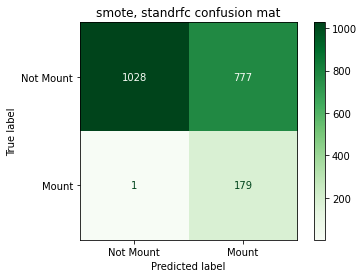

In [ ]:
#Importing essential libraries
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(training_features, training_labels)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
#scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
#print('Mean f1: %.3f' % mean(scores['test_f1']))
#print('Mean recall: %.3f' % mean(scores['test_recall']))
#print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels, test_size=0.1, stratify=training_labels)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['Not Mount', 'Mount'], cmap='Greens')
plt.title('smote, standrfc confusion mat')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(testing_features, training_labels, test_size=0.95, stratify=training_labels)
y_pred = SMOTE_SRF.predict(testing_features)
# Making the Confusion Matrix
print(pd.crosstab(testing_labels, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted      0     1
Actual                
0          10104  7936
1             43  1761


# save classifer

In [ ]:
# save the model
with open(output_dir + 'classifer_1202v5.pickle', 'wb') as f:
  pickle.dump(SMOTE_SRF, f)
#with open(output_dir + 'classifer_1202v5_scaler.pickle', 'wb') as f:
  #pickle.dump(scaler, f)

In [ ]:
# load the model
classifier_file = open(output_dir +'classifer_1202v4.pickle', 'rb')
classifier = pickle.load(classifier_file)
classifier_file.close()
scaler_file = open(output_dir +'classifer_1202v4_scaler.pickle', 'rb')
scaler = pickle.load(scaler_file)
scaler_file.close()